# FashionMNIST VAE

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import torch
import torchvision
import torchvision.transforms as tvt
import pyro
from pyro.infer import SVI, Trace_ELBO #, TraceGraph_ELBO
from pyro.optim import Adam, Adamax, Adadelta, SGD, RMSprop
from torchvision import utils
from helper_functions import *

### Define the simulation parameters

In [12]:
params = { 
    'CHANNELS' : 1,
    'WIDTH' : 28,
    'HEIGHT':28, 
    'DIM_Z':20,
    'SCALE': 1.0,
    'use_cuda' : torch.cuda.is_available()
    }
print(params)

{'CHANNELS': 1, 'WIDTH': 28, 'HEIGHT': 28, 'DIM_Z': 20, 'SCALE': 1.0, 'use_cuda': False}


### Get the data

torch.Size([512, 1, 28, 28])


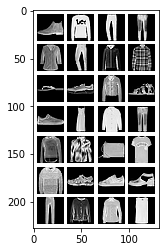

In [13]:
BATCH_SIZE = 512
kwargs = {'num_workers': 0, 'pin_memory': params["use_cuda"]}
#data_dir = "/home/jupyter/REPOS/VAE_PYRO"
#data_dir = "/home/ldalessi/REPOS/VAE_PYRO"
data_dir = "/Users/ldalessi/VAE_PYRO"


trainset = torchvision.datasets.FashionMNIST(data_dir, train=True, download=True, transform=tvt.ToTensor())
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, **kwargs)
testset = torchvision.datasets.FashionMNIST(data_dir, train=False, download=True, transform=tvt.ToTensor())
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, **kwargs)

imgs,labels = next(iter(testloader))

print(imgs.shape)
show_batch(imgs[:28],npadding=4)

### Instantiate VAE class 
This is the case without latent structure

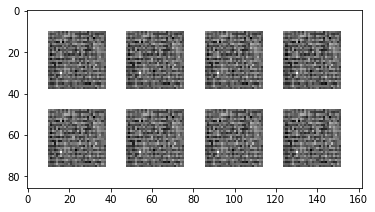

In [14]:
from encoder_decoder import *
from vae import *

encoder = Encoder_CONV(params)
decoder = Decoder_CONV(params)
vae = VAE(params,encoder,decoder)

vae.guide()
vae.model()
if(params['use_cuda']):
    imgs=imgs.cuda()
imgs_rec = vae.reconstruct(imgs)
show_batch(imgs_rec[:8])

In [15]:
pyro.clear_param_store()
pyro.set_rng_seed(0)

TEST_FREQUENCY = 5
WRITE_FREQUENCY = 20
smoke_test= False
if(smoke_test):
    pyro.enable_validation(True)
    pyro.distributions.enable_validation(True)
    NUM_EPOCHS = 21
else:
    pyro.enable_validation(False)
    pyro.distributions.enable_validation(False)
    NUM_EPOCHS = 101

In [16]:
#write_dir = "/home/jupyter/REPOS/VAE_PYRO/ARCHIVE/"
write_dir = "/home/ldalessi/REPOS/VAE_PYRO/ARCHIVE/"
write_dir = "/Users/ldalessi/VAE_PYRO/ARCHIVE/"

#descriptor      = "Fashion_MNIST_scale_1000.0"
descriptor      = "Fashion_TEST"
name_vae        = "vae_"+descriptor+"_"
name_train_loss = "train_loss_"+descriptor+"_"
name_test_loss  = "test_loss_"+descriptor+"_"
name_params     = "params_"+descriptor


save_obj(params,write_dir,name_params)

# PROFILE THE CODE

In [17]:
encoder = Encoder_CONV(params)
decoder = Decoder_CONV(params)
vae = VAE(params,encoder,decoder)
optimizer = Adam({"lr": 1.0e-6, "betas":(0.5, 0.5)})
svi = SVI(vae.model, vae.guide, optimizer, loss=Trace_ELBO(num_particles=1))

In [18]:
#optimizer = SGD({"lr": 0.001, "momentum" :0.9})
#optimizer = RMSprop({"lr": 0.001})

def lr_finder(model, svi, loader, start_lr=1E-6, end_lr=1, lr_multiplier=1.2, epoch_max=1, use_cuda=False):
    
    # preparation
    model.train() 
    svi.optim.pt_optim_args['lr'] = start_lr
    hist_loss = []
    hist_lr = []
    
    for epoch in range(0,epoch_max):
        for i,data in enumerate(loader):
                    
            # if on GPU put mini-batch into CUDA memory
            x, _ = data
            if use_cuda:
                x = x.cuda()
            loss = svi.step(x)
            
            print("epoch,mini_batch,lr,loss %.4d %.4d %.4e %.4f" %(epoch,i,svi.optim.pt_optim_args['lr'],loss))
            
            hist_loss.append(loss)
            hist_lr.append(svi.optim.pt_optim_args['lr'])
            svi.optim.pt_optim_args['lr'] *= lr_multiplier
                
            #except:
            #    return hist_loss,hist_lr
            
            if(np.isnan(loss)):
                print("loss is nan")
                return hist_loss,hist_lr
            if(svi.optim.pt_optim_args['lr']>end_lr):
                print("lr is bigger than end_lr")
                return hist_loss,hist_lr
    
    return hist_loss,hist_lr

In [19]:
hist_loss,hist_lr = lr_finder(vae, svi, trainloader, start_lr=1E-4, lr_multiplier=1.01, epoch_max=10)

epoch,mini_batch,lr,loss 0000 0000 1.0000e-04 2501524.1045
epoch,mini_batch,lr,loss 0000 0001 1.0100e-04 2362238.9463
epoch,mini_batch,lr,loss 0000 0002 1.0201e-04 2288370.2012
epoch,mini_batch,lr,loss 0000 0003 1.0303e-04 2337417.2520
epoch,mini_batch,lr,loss 0000 0004 1.0406e-04 2050502.3447
epoch,mini_batch,lr,loss 0000 0005 1.0510e-04 2098594.8936
epoch,mini_batch,lr,loss 0000 0006 1.0615e-04 1969949.1621
epoch,mini_batch,lr,loss 0000 0007 1.0721e-04 1960899.8877
epoch,mini_batch,lr,loss 0000 0008 1.0829e-04 1991071.6475
epoch,mini_batch,lr,loss 0000 0009 1.0937e-04 1856505.1055
epoch,mini_batch,lr,loss 0000 0010 1.1046e-04 1916675.5498
epoch,mini_batch,lr,loss 0000 0011 1.1157e-04 1813426.4619
epoch,mini_batch,lr,loss 0000 0012 1.1268e-04 1792011.3213
epoch,mini_batch,lr,loss 0000 0013 1.1381e-04 1735479.0625
epoch,mini_batch,lr,loss 0000 0014 1.1495e-04 1769898.7939
epoch,mini_batch,lr,loss 0000 0015 1.1610e-04 1689144.5010
epoch,mini_batch,lr,loss 0000 0016 1.1726e-04 1715389.79

KeyboardInterrupt: 

In [ ]:
#print(hist_loss,hist_lr)
#plt.plot(hist_lr,hist_loss)
plt.plot(hist_loss)

In [ ]:
a = svi.optim.pt_optim_args
print(a)

In [ ]:
#optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
#scheduler = torch.optim.CyclicLR(optimizer)
#torch.optim.lr_scheduler.StepLR
#for epoch inrange(10):train_batch(...)scheduler.step()
#optimizer = SGD({"lr": 1.0e-3, "betas":(0.9, 0.999)})

In [ ]:
# training loop
for epoch in range(0,NUM_EPOCHS):
    vae.train()            
       
    loss = train(svi,trainloader,use_cuda=params['use_cuda'],verbose=(epoch ==0))
    train_loss.append(loss)   
    print("[epoch %03d] train loss: %.4f" % (epoch, loss))
    
    if(epoch % TEST_FREQUENCY == 0):
        vae.eval()
        loss = evaluate(svi,testloader,use_cuda=params['use_cuda'],verbose=(epoch ==0))
        test_loss.append(loss)
    
        if(test_loss[-1] < min_loss):
            print("[epoch %03d] test  loss: %.4f --New Record--" % (epoch, loss)) 
            min_loss = test_loss[-1]
            #### Save if you got a record 
            ###save_model(vae,write_dir,name_vae+str(epoch))       
            ###save_obj(test_loss,write_dir,name_test_loss+str(epoch))
            ###save_obj(train_loss,write_dir,name_train_loss+str(epoch))
        else:
            print("[epoch %03d] test  loss: %.4f " % (epoch, loss))
            
    if(epoch % WRITE_FREQUENCY == 0):
        save_model(vae,write_dir,name_vae+str(epoch))       
        save_obj(test_loss,write_dir,name_test_loss+str(epoch))
        save_obj(train_loss,write_dir,name_train_loss+str(epoch))


# Check the results

In [ ]:
#write_dir = '/Users/ldalessi/VAE_PYRO/ARCHIVE/'

#descriptor      = "MNIST_v1"

#load_model(vae,write_dir,"vae_"+descriptor+"_400")
#test_loss = load_obj(write_dir,"test_loss_"+descriptor+"_400")
#train_loss = load_obj(write_dir,"train_loss_"+descriptor+"_400")
#name_vae = "vae_"+descriptor

In [ ]:
from matplotlib import pyplot as plt

plt.yscale('log')
y_shift=1000
x_shift=0
plt.plot(np.arange(x_shift, x_shift+len(train_loss)), np.array(train_loss)+y_shift)
plt.plot(np.arange(x_shift, x_shift+len(train_loss), TEST_FREQUENCY), np.array(test_loss)+y_shift, '.--')
plt.xlabel('epoch')
plt.ylabel('LOSS = - ELBO')
plt.title('Training procedure')
#plt.ylim(top = 760)
#plt.xlim(xmin = 0, xmax=700)
plt.grid(True)
plt.legend(['train', 'test'])
#plt.show()


plt.savefig(write_dir+name_vae+'train.png')

In [ ]:
#imgs,labels = next(iter(testloader))
imgs,labels = next(iter(trainloader))
if(params['use_cuda']):
    imgs=imgs.cuda()
imgs_rec = vae.reconstruct(imgs)
show_2_batch(imgs[:12],imgs_rec[:12],npadding=4,nrow=6)
plt.savefig(write_dir+name_vae+'rec.png')

# compute the embedding

In [ ]:
z_tot      = np.empty([0,params['DIM_Z']])
labels_tot = np.empty([0])
for data in testloader:
    if z_tot.shape[0] >= 6000:
        break

    imgs,labels = data
    if(params['use_cuda']):
        imgs=imgs.cuda()
    z = vae.encoder(imgs)

    z_tot = np.concatenate((z_tot, z.z_mu.view(-1,params['DIM_Z']).detach().cpu().numpy()),axis=0)
    labels_tot = np.concatenate((labels_tot, labels.numpy()),axis=0)

print("z_tot.shape",z_tot.shape)
print("labels_tot.shape",labels_tot.shape)

# Clear the data

In [ ]:
z_tot[np.isnan(z_tot)] = 0
z_tot[z_tot > 100] = 0
print(z_tot.shape)
print(z_tot[labels_tot==0].shape)
print(labels_tot.shape)

In [ ]:
for k in np.unique(labels_tot):
    plt.plot(z_tot[labels_tot==k, 0], 
             z_tot[labels_tot==k, 1], '.', ms=8, alpha=0.5)

       
lgnd = plt.legend(np.unique(labels_tot).astype(int), 
                  loc='center left', bbox_to_anchor=(1, 0.5))
for i in range(len(lgnd.legendHandles)):
    lgnd.legendHandles[i]._legmarker.set_markersize(20)
    lgnd.legendHandles[i]._legmarker.set_alpha(1)

plt.xlabel('z 0')
plt.ylabel('z 1')
plt.title('Visualization of raw z')
plt.box(on=None)
plt.savefig(write_dir+name_vae+'raw_z.png')

In [ ]:
cluster = dict()

for k in np.unique(labels_tot):
    mean_tmp = np.mean(z_tot[labels_tot == k],axis=0)
    #print(mean_tmp.shape)
    cluster[int(k)] = mean_tmp
cluster['all']=np.mean(z_tot,axis=0)
    

In [ ]:
print(cluster)

In [ ]:

for key in range(10):
    mean = cluster[key]
    plt.plot(mean[0],mean[1],'.', ms=20, alpha=1,label=key)
plt.plot(cluster['all'][0],cluster['all'][1],'x', ms=10, alpha=1,label='all')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.box(on=None)
plt.savefig(write_dir+name_vae+'cluster_center.png')

In [ ]:
# and I know this sounds ridiculous but we have to do more
# dimensionality reduction to visualize our dimensionality reduction

from sklearn.manifold import TSNE
z_tsne = TSNE(n_components=2).fit_transform(z_tot)

In [ ]:
plt.rcParams.update({'font.size': 14})

plt.figure(figsize=(8, 8), frameon=False)
for k in np.unique(labels_tot):
    plt.plot(z_tsne[labels_tot==k, 0], 
             z_tsne[labels_tot==k, 1], '.', ms=8, alpha=0.5)

lgnd = plt.legend(np.unique(labels_tot).astype(int), 
                  loc='center left', bbox_to_anchor=(1, 0.5))
for i in range(len(lgnd.legendHandles)):
    lgnd.legendHandles[i]._legmarker.set_markersize(20)
    lgnd.legendHandles[i]._legmarker.set_alpha(1)

plt.xlabel('TSNE 0')
plt.ylabel('TSNE 1')
plt.title('Visualization of embedding')
plt.box(on=None)
plt.savefig(write_dir+name_vae+'embedding.png')